In [41]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from influxdb_client import InfluxDBClient
from hmmlearn import hmm
from sklearn.preprocessing import StandardScaler
from datetime import datetime, timedelta
import joblib
import warnings
warnings.filterwarnings('ignore')  # Suppress warnings for cleaner output

from dotenv import load_dotenv
from loguru import logger

data_path = os.path.abspath("C:\\Users\\tyjch\\PycharmProjects\\time-series\\src")
sys.path.append(data_path)

load_dotenv('../.env')
from data import DataframeManager

In [42]:
# Set up plotting style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_context("notebook", font_scale=1.2)

# Set Matplotlib parameters for better readability
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['font.size'] = 12

# Ignore InfluxDB warnings
warnings.simplefilter("ignore", MissingPivotFunction)

# Ignore debug logs from loguru
logger.remove()
logger.add('logfile.log', level='INFO')

4

In [43]:
manager = DataframeManager(time_range='7d')
df = manager.get_merged_dataframe(fill_missing=True)

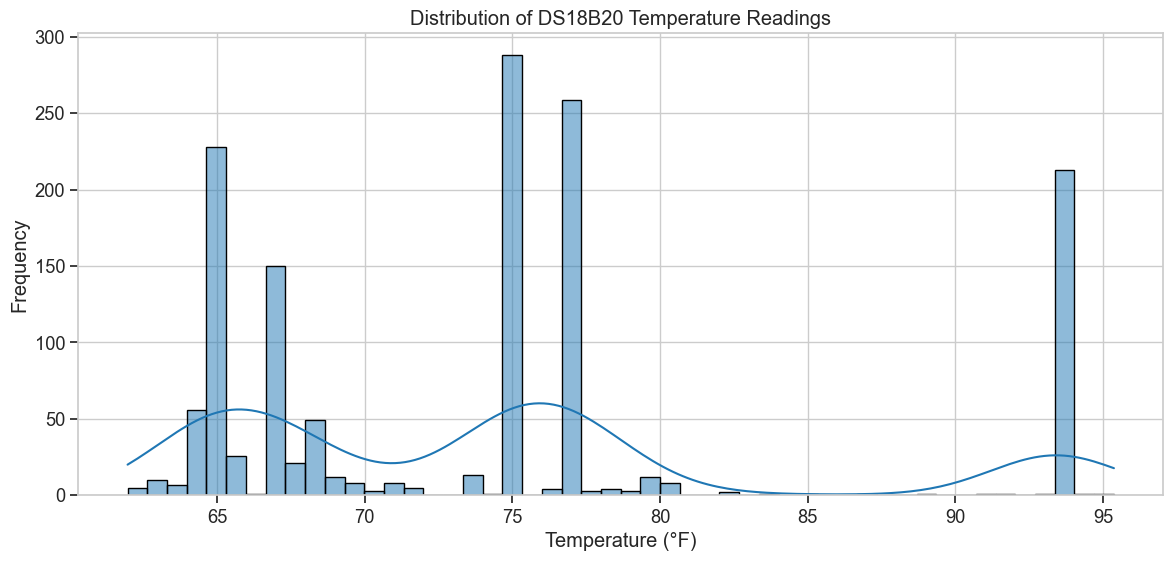

In [44]:
plt.figure(figsize=(14, 6))
sns.histplot(df['core'], bins=50, kde=True)
plt.title('Distribution of DS18B20 Temperature Readings')
plt.xlabel('Temperature (°F)')
plt.ylabel('Frequency')
plt.savefig('ds18b20_histogram.png')
plt.show()

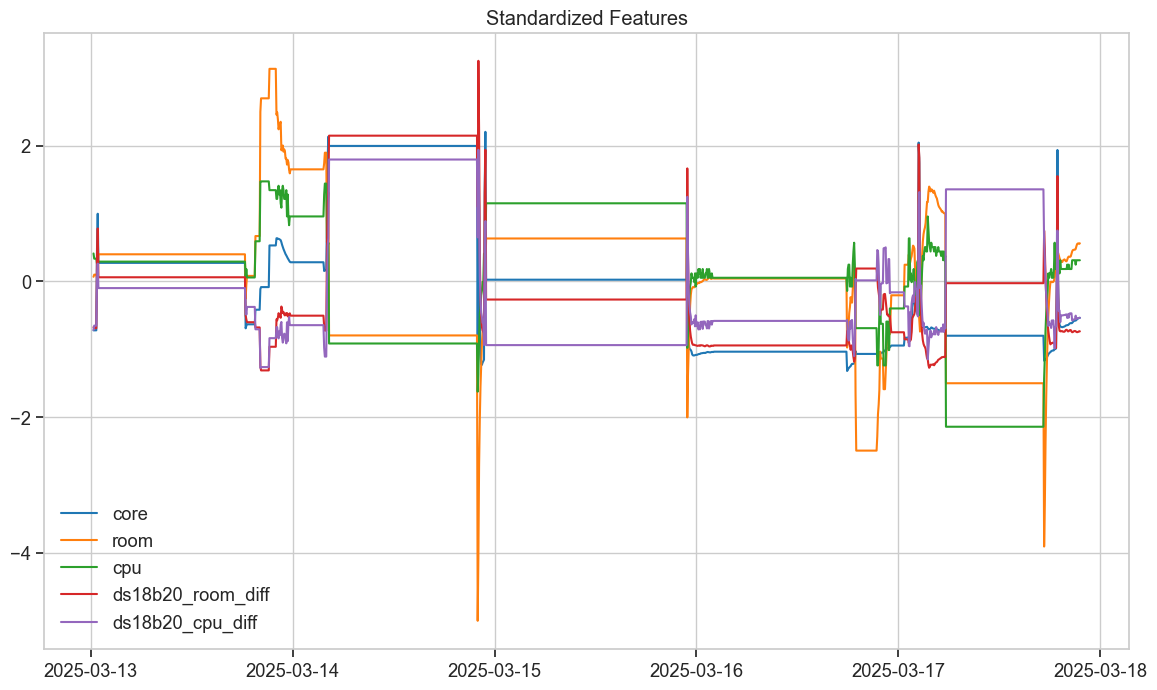

In [45]:
df['ds18b20_room_diff'] = df['core'] - df['room']
df['ds18b20_cpu_diff'] = df['core'] - df['cpu']
df['room_cpu_diff'] = df['room'] - df['cpu']

# Create feature matrix
feature_cols = ['core', 'room', 'cpu', 
                'ds18b20_room_diff', 'ds18b20_cpu_diff']
X = df[feature_cols].values

# Standardize features (important for HMM)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Create a DataFrame of scaled features for easier reference
scaled_df = pd.DataFrame(X_scaled, index=df.index, columns=feature_cols)

# Visualize the scaled features
plt.figure(figsize=(14, 8))
for col in scaled_df.columns:
    plt.plot(scaled_df.index, scaled_df[col], label=col)
plt.title('Standardized Features')
plt.legend()
plt.savefig('hmm_standardized_features.png')
plt.show()

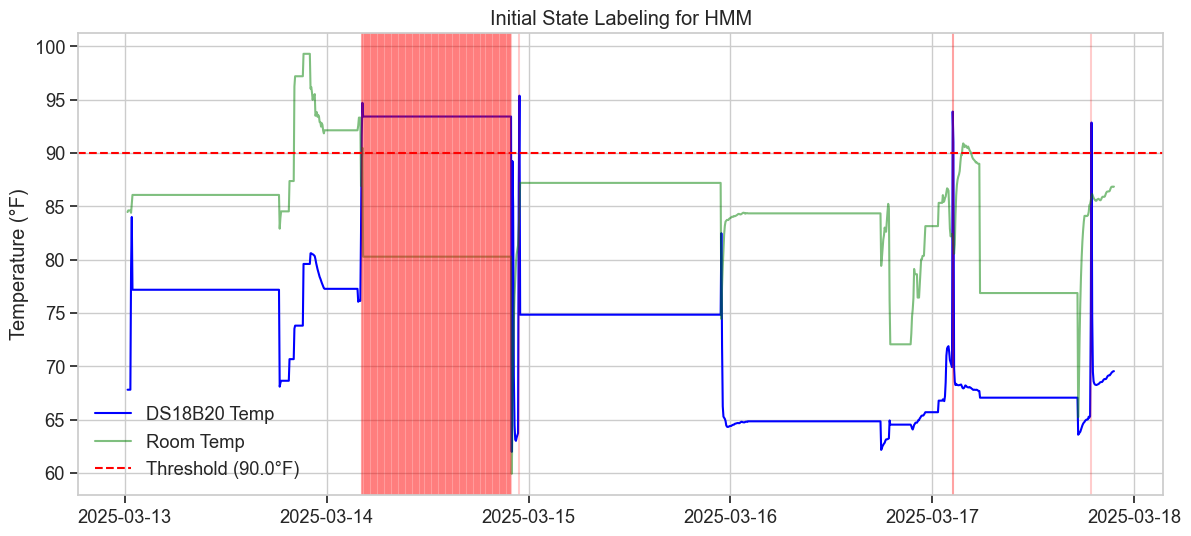


Initial labeling: {0: 1190, 1: 218}
  State 0 (Disconnected): 1190 data points
  State 1 (Connected): 218 data points


In [46]:
# Assuming body temperature is typically above 90°F
body_temp_threshold = 90.0
df['initial_label'] = (df['core'] > body_temp_threshold).astype(int)

# Visualize initial labeling
plt.figure(figsize=(14, 6))
plt.plot(df.index, df['core'], 'b-', label='DS18B20 Temp')
plt.plot(df.index, df['room'], 'g-', alpha=0.5, label='Room Temp')

# Highlight regions based on initial labels
connected_regions = df[df['initial_label'] == 1]
for idx, row in connected_regions.iterrows():
    plt.axvline(x=idx, color='r', alpha=0.2)

plt.axhline(y=body_temp_threshold, color='r', linestyle='--', label=f'Threshold ({body_temp_threshold}°F)')
plt.title('Initial State Labeling for HMM')
plt.ylabel('Temperature (°F)')
plt.legend()
plt.savefig('hmm_initial_labeling.png')
plt.show()

print(f"\nInitial labeling: {df['initial_label'].value_counts().to_dict()}")
print(f"  State 0 (Disconnected): {df['initial_label'].value_counts().get(0, 0)} data points")
print(f"  State 1 (Connected): {df['initial_label'].value_counts().get(1, 0)} data points")

In [47]:
n_states = 2  # Connected and Disconnected states

# Create the HMM model
model = hmm.GaussianHMM(
    n_components=n_states,
    covariance_type="full",  # Full covariance matrix for flexibility
    n_iter=100,              # Maximum number of iterations
    random_state=42,         # For reproducibility
    verbose=True
)

# Initialize parameters based on our initial labeling
# This helps the model converge to a meaningful solution

# Start probabilities: proportion of each state in initial labels
start_prob = np.zeros(n_states)
for i in range(n_states):
    start_prob[i] = (df['initial_label'] == i).mean()
model.startprob_ = start_prob

# Transition probabilities: estimated from labeled sequences
# We'll calculate how often it transitions from one state to another
trans_mat = np.zeros((n_states, n_states))
for i in range(len(df) - 1):
    from_state = df['initial_label'].iloc[i]
    to_state   = df['initial_label'].iloc[i + 1]
    trans_mat[from_state, to_state] += 1

# Normalize rows to get probabilities
for i in range(n_states):
    row_sum = trans_mat[i].sum()
    if row_sum > 0:
        trans_mat[i] = trans_mat[i] / row_sum
model.transmat_ = trans_mat

# Initialize means and covariances
means = np.zeros((n_states, X_scaled.shape[1]))
covars = np.zeros((n_states, X_scaled.shape[1], X_scaled.shape[1]))

for i in range(n_states):
    state_data = X_scaled[df['initial_label'] == i]
    if len(state_data) > 0:
        means[i] = np.mean(state_data, axis=0)
        
        # Use a more conservative approach for covariance
        # Start with identity matrix and add a scaled version of empirical covariance
        empirical_cov = np.cov(state_data, rowvar=False)
        if np.isnan(empirical_cov).any() or np.isinf(empirical_cov).any():
            covars[i] = np.eye(X_scaled.shape[1])
        else:
            # Ensure symmetry
            empirical_cov = (empirical_cov + empirical_cov.T) / 2
            
            # Create regularized covariance (shrinkage toward identity)
            alpha = 0.5  # Shrinkage parameter between 0 and 1
            reg_cov = alpha * empirical_cov + (1 - alpha) * np.eye(X_scaled.shape[1])
            
            # Add additional regularization to ensure positive definiteness
            min_eig = np.min(np.linalg.eigvalsh(reg_cov))
            if min_eig < 0.01:
                reg_cov += (0.01 - min_eig) * np.eye(X_scaled.shape[1])
                
            covars[i] = reg_cov
    else:
        # Fallback if no data for a state
        means[i] = np.zeros(X_scaled.shape[1])
        covars[i] = np.eye(X_scaled.shape[1])

model.means_ = means
model.covars_ = covars

# Print initial parameters
print("\nInitial HMM Parameters:")
print(f"Start probabilities: {model.startprob_}")
print(f"Transition matrix:\n{model.transmat_}")
print(f"Means:\n{model.means_}")


Initial HMM Parameters:
Start probabilities: [0.84517045 0.15482955]
Transition matrix:
[[0.99663583 0.00336417]
 [0.01834862 0.98165138]]
Means:
[[-0.36547706  0.14043016  0.16212495 -0.39063236 -0.32420692]
 [ 1.99503532 -0.7665683  -0.88499401  2.13235094  1.76975337]]


Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'
Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
         1     981.65775142             +nan
         2   22794.84735062  +21813.18959920
         3   22764.15553293     -30.69181769
Model is not converging.  Current: 22764.155532930232 is not greater than 22794.847350617878. Delta is -30.691817687646108



HMM training successful!
Log likelihood: 22162.29
Number of iterations: 3

Learned HMM Parameters:
Start probabilities: [1.00000000e+00 1.11658189e-10]
Transition matrix:
[[0.96831285 0.03168715]
 [0.96384147 0.03615853]]
Means:
[[-0.03354368  0.0342122   0.04405206 -0.04563024 -0.05389649]
 [ 1.02106125 -1.04141091 -1.34093381  1.3889734   1.64059585]]

Analyzing HMM results...


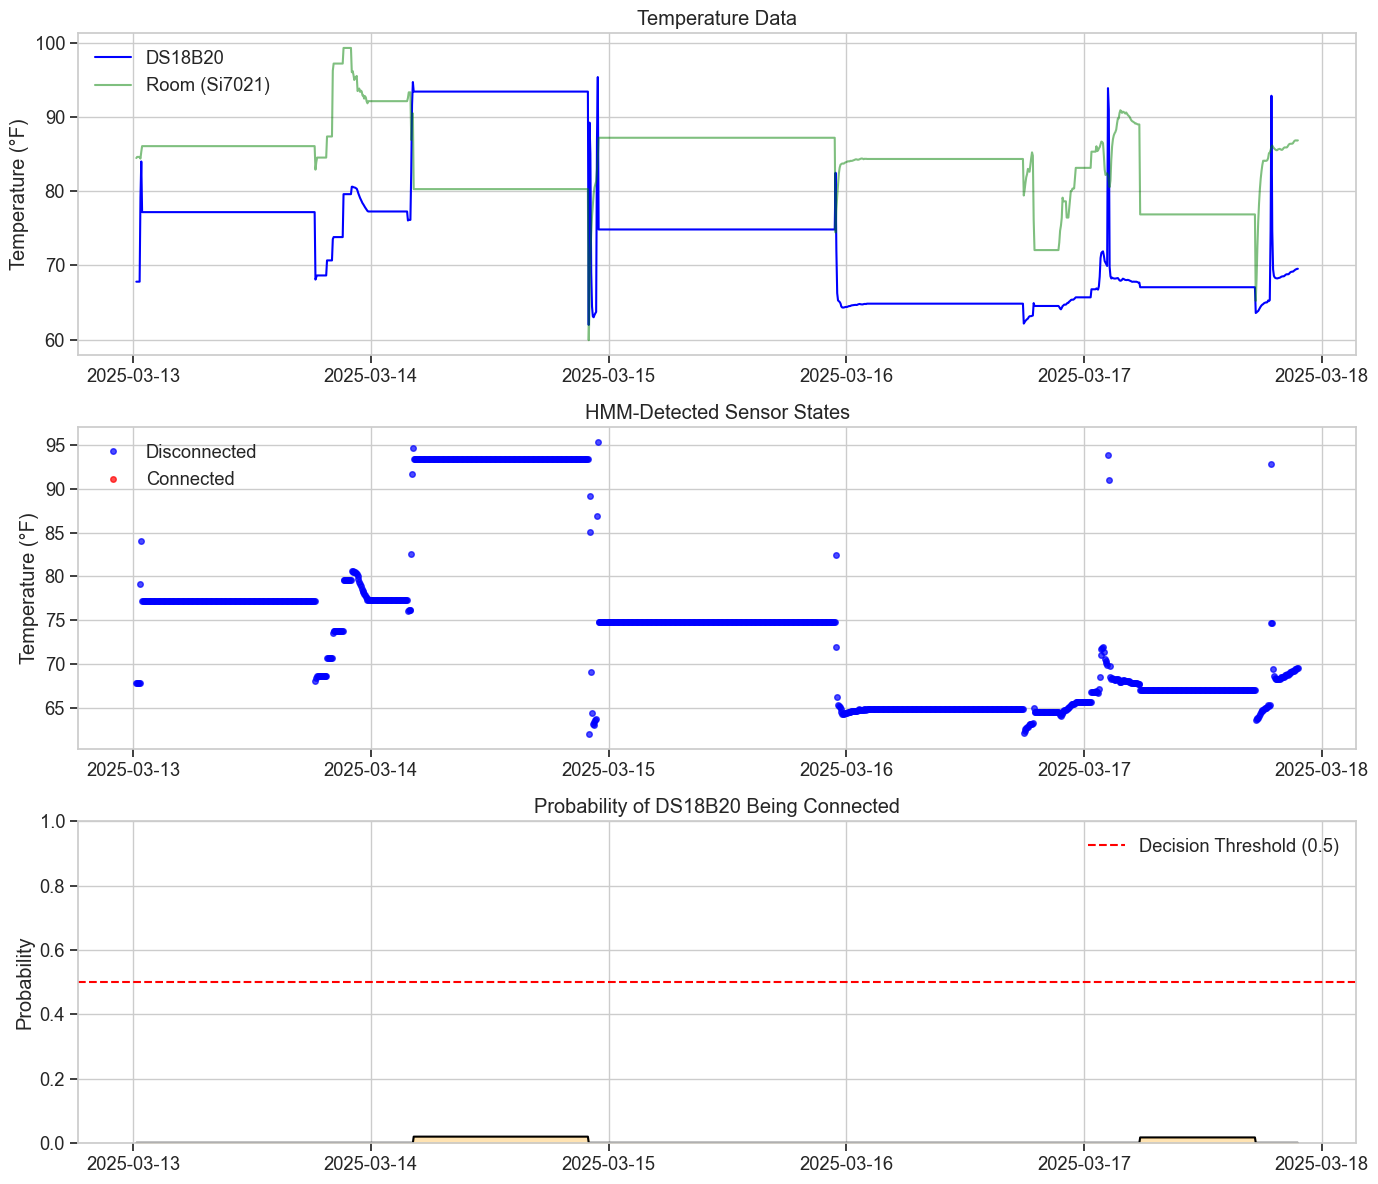


Detected 0 state transitions:

Agreement between threshold-based and HMM detection: 84.52%

Comparison of detection methods:
HMM                  0
Threshold (90°F)      
0                 1190
1                  218

Analyzing temperature distributions by detected state...

DS18B20 temperature statistics by state:
                mean       std        min        max
hmm_state                                           
0          74.599459  9.430497  61.967923  95.368606


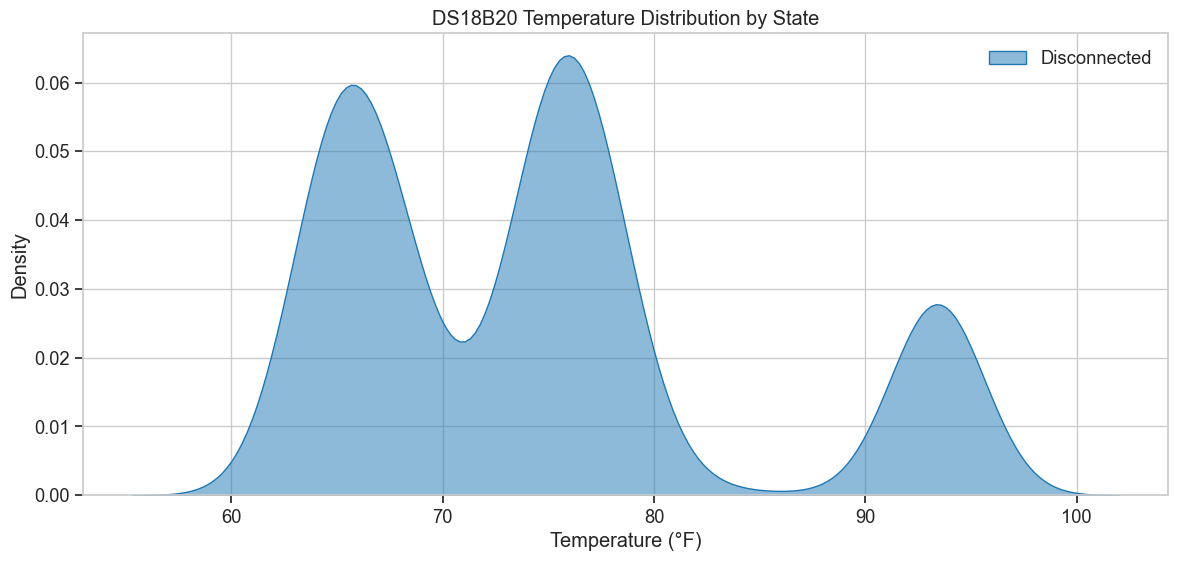


Creating a reusable detection function...

Detection result for the most recent data point:
core: 69.53453214285706
room: 86.8410122070312
cpu: 124.77199999999996
is_connected: False
connected_probability: 0.0
disconnected_probability: 1.0

Saved model and parameters to 'ds18b20_hmm_model.pkl'

    # Summary and Recommendations
    # =========================
    
    This notebook demonstrates how to use Hidden Markov Models to detect when the DS18B20 
    temperature sensor is connected to a human body versus when it's disconnected and 
    measuring ambient temperature.
    
    Key findings:
    1. HMMs can effectively capture the hidden connection state from temperature readings
    2. The model learns the probability distributions for each state and transitions between them
    3. We get a confidence score (probability) rather than just a binary decision
    
    Advantages of the HMM approach:
    1. More robust to noise and temperature fluctuations
    2. Considers temporal pa

In [48]:
try:
    model.fit(X_scaled)
    print("\nHMM training successful!")
    print(f"Log likelihood: {model.score(X_scaled):.2f}")
    print(f"Number of iterations: {model.monitor_.iter}")
    
    # Print learned parameters
    print("\nLearned HMM Parameters:")
    print(f"Start probabilities: {model.startprob_}")
    print(f"Transition matrix:\n{model.transmat_}")
    print(f"Means:\n{model.means_}")
    
    # 7. Analyzing the HMM Results
    # ===========================
    print("\nAnalyzing HMM results...")
    
    # 7.1 Decode the most likely sequence of states
    hidden_states = model.predict(X_scaled)
    df['hmm_state'] = hidden_states
    
    # Adjust states if necessary to match our expectations
    # Sometimes the HMM might flip the states (0=connected, 1=disconnected)
    # We'll check if state 1 has higher DS18B20 temps on average
    state0_mean = df[df['hmm_state'] == 0]['core'].mean()
    state1_mean = df[df['hmm_state'] == 1]['core'].mean()
    
    # If state 0 has higher temps, it should be the "connected" state - flip the labels
    if state0_mean > state1_mean:
        print("\nFlipping state labels to match expectations (0=disconnected, 1=connected)")
        df['hmm_state'] = 1 - df['hmm_state']
    
    # 7.2 Calculate state probabilities
    # The forward-backward algorithm gives us probabilities for each state at each time
    state_probs = model.predict_proba(X_scaled)
    
    # If we flipped the states, also flip the probabilities
    if state0_mean > state1_mean:
        state_probs = 1 - state_probs
    
    # Add probabilities to DataFrame
    df['connected_prob'] = state_probs[:, 1]  # Probability of being in "connected" state
    
    # 7.3 Visualize the results
    plt.figure(figsize=(14, 12))
    
    # Plot 1: Original temperature data
    plt.subplot(3, 1, 1)
    plt.plot(df.index, df['core'], 'b-', label='DS18B20')
    plt.plot(df.index, df['room'], 'g-', alpha=0.5, label='Room (Si7021)')
    plt.title('Temperature Data')
    plt.ylabel('Temperature (°F)')
    plt.legend()
    
    # Plot 2: HMM-decoded states
    plt.subplot(3, 1, 2)
    for state in [0, 1]:
        mask = df['hmm_state'] == state
        label = 'Connected' if state == 1 else 'Disconnected'
        color = 'red' if state == 1 else 'blue'
        plt.plot(df.index[mask], df['core'][mask], 
                 'o', markersize=4, alpha=0.7, color=color, label=label)
    plt.title('HMM-Detected Sensor States')
    plt.ylabel('Temperature (°F)')
    plt.legend()
    
    # Plot 3: Connection probability
    plt.subplot(3, 1, 3)
    plt.plot(df.index, df['connected_prob'], 'k-')
    plt.fill_between(df.index, 0, df['connected_prob'], alpha=0.3, color='orange')
    plt.axhline(y=0.5, color='r', linestyle='--', label='Decision Threshold (0.5)')
    plt.title('Probability of DS18B20 Being Connected')
    plt.ylabel('Probability')
    plt.ylim(0, 1)
    plt.legend()
    
    plt.tight_layout()
    plt.savefig('hmm_results.png')
    plt.show()
    
    # 7.4 Analyze state transitions
    # Let's find where the sensor changes state
    df['state_change'] = df['hmm_state'].diff().abs() > 0
    transitions = df[df['state_change']]
    
    print(f"\nDetected {len(transitions)} state transitions:")
    if len(transitions) > 0:
        for i, (idx, row) in enumerate(transitions.iterrows()):
            state = "connected" if row['hmm_state'] == 1 else "disconnected"
            print(f"  {i+1}. {idx.strftime('%Y-%m-%d %H:%M:%S')}: Sensor became {state}")
    
    # 7.5 Compare with threshold-based approach
    agreement = (df['hmm_state'] == df['initial_label']).mean() * 100
    print(f"\nAgreement between threshold-based and HMM detection: {agreement:.2f}%")
    
    # Confusion matrix-like comparison
    confusion = pd.crosstab(
        df['initial_label'], 
        df['hmm_state'],
        rownames=['Threshold (90°F)'],
        colnames=['HMM']
    )
    
    print("\nComparison of detection methods:")
    print(confusion)
    
    # 7.6 Analyze observation distributions
    print("\nAnalyzing temperature distributions by detected state...")
    
    # Temperature statistics by state
    state_stats = df.groupby('hmm_state')['core'].agg(['mean', 'std', 'min', 'max'])
    print("\nDS18B20 temperature statistics by state:")
    print(state_stats)
    
    # Visualize temperature distributions
    plt.figure(figsize=(14, 6))
    for state in [0, 1]:
        label = 'Connected' if state == 1 else 'Disconnected'
        data = df[df['hmm_state'] == state]['core']
        sns.kdeplot(data, label=label, fill=True, alpha=0.5)
    
    plt.title('DS18B20 Temperature Distribution by State')
    plt.xlabel('Temperature (°F)')
    plt.ylabel('Density')
    plt.legend()
    plt.savefig('hmm_temperature_distributions.png')
    plt.show()
    
    # 8. Creating a Reusable Detection Function
    # =======================================
    print("\nCreating a reusable detection function...")
    
    def detect_connection_hmm(core, room, cpu, model=model, scaler=scaler):
        """
        Detect if the DS18B20 sensor is connected using the HMM model.
        
        Parameters:
        -----------
        core : float
            Current DS18B20 temperature reading (°F)
        room : float
            Current room temperature from Si7021 (°F)
        cpu : float
            Current CPU temperature (°F)
        model : hmmlearn.hmm.GaussianHMM
            Trained HMM model
        scaler : sklearn.preprocessing.StandardScaler
            Fitted scaler for feature standardization
            
        Returns:
        --------
        dict
            Dictionary containing detection results and diagnostics
        """
        # Calculate derived features
        ds18b20_room_diff = core - room
        ds18b20_cpu_diff = core - cpu
        
        # Create feature vector
        X = np.array([[core, room, cpu, 
                       ds18b20_room_diff, ds18b20_cpu_diff]])
        
        # Standardize features
        X_scaled = scaler.transform(X)
        
        # Get state prediction and probability
        state = model.predict(X_scaled)[0]
        state_probs = model.predict_proba(X_scaled)[0]
        
        # Adjust if necessary (if states were flipped)
        if state0_mean > state1_mean:
            state = 1 - state
            state_probs = state_probs[::-1]
        
        # Create result
        result = {
            'core': core,
            'room': room,
            'cpu': cpu,
            'is_connected': state == 1,
            'connected_probability': state_probs[1],
            'disconnected_probability': state_probs[0]
        }
        
        return result
    
    # Test the function with the last data point
    last_point = df.iloc[-1]
    detection_result = detect_connection_hmm(
        last_point['core'],
        last_point['room'],
        last_point['cpu'],
        model=model,
        scaler=scaler
    )
    
    print("\nDetection result for the most recent data point:")
    for key, value in detection_result.items():
        print(f"{key}: {value}")
    
    # 9. Save the Model for Later Use
    # =============================
    # Save the HMM model and scaler
    joblib.dump({
        'model': model,
        'scaler': scaler,
        'state0_mean': state0_mean,
        'state1_mean': state1_mean
    }, 'ds18b20_hmm_model.pkl')
    
    print("\nSaved model and parameters to 'ds18b20_hmm_model.pkl'")
    
    # 10. Final Recommendations
    # =======================
    print("""
    # Summary and Recommendations
    # =========================
    
    This notebook demonstrates how to use Hidden Markov Models to detect when the DS18B20 
    temperature sensor is connected to a human body versus when it's disconnected and 
    measuring ambient temperature.
    
    Key findings:
    1. HMMs can effectively capture the hidden connection state from temperature readings
    2. The model learns the probability distributions for each state and transitions between them
    3. We get a confidence score (probability) rather than just a binary decision
    
    Advantages of the HMM approach:
    1. More robust to noise and temperature fluctuations
    2. Considers temporal patterns and state transitions
    3. Provides probabilistic output for better decision-making
    4. Less reliant on fixed thresholds
    
    Recommendations for implementation:
    1. Retrain the model periodically as more data becomes available
    2. Consider using a sliding window approach for online detection
    3. Combine with the residual analysis method for higher confidence
    4. Implement a "stabilization" phase after detected transitions
    
    Next steps:
    1. Evaluate with ground truth data where connection status is known
    2. Consider a more complex model with more states (e.g., disconnected, 
       stabilizing, connected, mispositioned)
    3. Explore other features like temperature derivatives
    """)

except Exception as e:
    print(f"Error training HMM: {e}")
    print("Please check your data or try a different initialization strategy.")